In [94]:
import os
import sys
import random
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sumolib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import cv2

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
from sumolib import checkBinary
# sumoBinary = checkBinary('sumo-gui')
sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
Using device: cuda


In [38]:
def randomTrips(dur=10000, density=12):
    os.system("python $SUMO_HOME/tools/randomTrips.py -n config/osm.net.xml.gz -r config/osm.passenger.trips.xml -e " + str(dur) + " -l --insertion-density=" + str(density))

def shouldContinueSim():
    numVehicles = traci.simulation.getMinExpectedNumber()
    return True if numVehicles > 0 else False

def restart(dur, density):
    try:
        traci.close()
    except:
        pass
    randomTrips(dur, density)
    traci.start(sumoCmd)
    step = 0
    for i in range(100):
        traci.simulationStep()
        step += 1

In [39]:
def intervehicleConnectivity(threshold = None, ids = traci.vehicle.getIDList()):
    xs = []
    ys = []
    for vehicle in ids:
        x, y = traci.vehicle.getPosition(vehicle)
        xs.append(x)
        ys.append(y)
    xs_t = torch.tensor(xs, dtype=torch.float32).to(device).view(-1,1)
    ys_t = torch.tensor(ys, dtype=torch.float32).to(device).view(-1,1)
    intervehicle_distances = torch.sqrt((xs_t - xs_t.t())**2 + (ys_t - ys_t.t())**2)
    # check the distance between the first two vehicles
    x1, y1 = (traci.vehicle.getPosition(ids[0]))
    x2, y2 = (traci.vehicle.getPosition(ids[1]))
    if threshold is not None:
        intervehicle_distances = torch.where(intervehicle_distances < threshold, torch.ones_like(intervehicle_distances), torch.zeros_like(intervehicle_distances))
    return intervehicle_distances, xs, ys

FatalTraCIError: Not connected.

In [40]:
def getObserved(grid_size = 128, cell_size = 10):
    dsrc_range = grid_size * cell_size / 2
    ids = traci.vehicle.getIDList()
    connectivity, xs, ys = intervehicleConnectivity(dsrc_range, ids)
    grids = torch.zeros(len(ids), 10, grid_size, grid_size).to(device)

    vehicle_speeds = [traci.vehicle.getSpeed(vehicle) for vehicle in ids]
    vehicle_directions = [traci.vehicle.getAngle(vehicle) for vehicle in ids]

    for i in range(len(ids)):
        x = xs[i]
        y = ys[i]
        storage = [[[[],[],[],[]] for x in range(grid_size)] for y in range(grid_size)]
        for j in range(len(ids)):
            if connectivity[i][j] == 1:
                x_grid = int((xs[j]-x + dsrc_range) / cell_size)
                y_grid = int((ys[j]-y + dsrc_range) / cell_size)
                direction = vehicle_directions[j]
                speed = vehicle_speeds[j]
                if grids[i][0][y_grid][x_grid] == 0:
                    grids[i][0][y_grid][x_grid] += 1
                    grids[i][1][y_grid][x_grid] = speed
                    grids[i][3][y_grid][x_grid] = direction
                    storage[y_grid][x_grid][0].append(speed)
                    storage[y_grid][x_grid][2].append(direction)
                elif grids[i][5][y_grid][x_grid] == 0 and 90<abs(direction - grids[i][3][y_grid][x_grid])<270:
                    grids[i][5][y_grid][x_grid] += 1
                    grids[i][6][y_grid][x_grid] = speed
                    grids[i][8][y_grid][x_grid] = direction
                    storage[y_grid][x_grid][1].append(speed)
                    storage[y_grid][x_grid][3].append(direction)
                else:
                    if abs(direction - grids[i][3][y_grid][x_grid]) < abs(direction - grids[i][8][y_grid][x_grid]):
                        grids[i][1][y_grid][x_grid] *= grids[i][0][y_grid][x_grid]
                        grids[i][1][y_grid][x_grid] += speed
                        grids[i][3][y_grid][x_grid] *= grids[i][0][y_grid][x_grid]
                        grids[i][3][y_grid][x_grid] += direction
                        grids[i][0][y_grid][x_grid] += 1
                        grids[i][1][y_grid][x_grid] /= grids[i][0][y_grid][x_grid]
                        grids[i][3][y_grid][x_grid] /= grids[i][0][y_grid][x_grid]
                        storage[y_grid][x_grid][0].append(speed)
                        storage[y_grid][x_grid][2].append(direction)
                    else:
                        grids[i][6][y_grid][x_grid] *= grids[i][5][y_grid][x_grid]
                        grids[i][6][y_grid][x_grid] += speed
                        grids[i][8][y_grid][x_grid] *= grids[i][5][y_grid][x_grid]
                        grids[i][8][y_grid][x_grid] += direction
                        grids[i][5][y_grid][x_grid] += 1
                        grids[i][6][y_grid][x_grid] /= grids[i][5][y_grid][x_grid]
                        grids[i][8][y_grid][x_grid] /= grids[i][5][y_grid][x_grid]
                        storage[y_grid][x_grid][1].append(speed)
                        storage[y_grid][x_grid][3].append(direction)
        for y in range(grid_size):
            for x in range(grid_size):
                # add the std of the speeds and directions
                if storage[y][x][0]:
                    grids[i][2][y][x] = np.std(storage[y][x][0])
                    grids[i][4][y][x] = np.std(storage[y][x][2])
                if storage[y][x][1]:
                    grids[i][7][y][x] = np.std(storage[y][x][1])
                    grids[i][9][y][x] = np.std(storage[y][x][3])
    return grids
            


In [147]:
restart(10000, 36)
a = getObserved()

Simulation ended at time: 100.00
Reason: TraCI requested termination.
Performance: 
 Duration: 19.35s
 TraCI-Duration: 0.01s
 Real time factor: 5.16929
 UPS: 127.061256
Vehicles: 
 Inserted: 50 (Loaded: 99)
 Running: 48
 Waiting: 0
Statistics (avg of 2):
 RouteLength: 382.23
 Speed: 6.12
 Duration: 62.50
 WaitingTime: 1.50
 TimeLoss: 13.44
 DepartDelay: 0.19

Success.
 Retrying in 1 seconds
***Starting server on port 34873 ***
Loading net-file from './config/osm.net.xml.gz' ... done (68ms).
Loading additional-files from './config/osm.poly.xml.gz' ... done (164ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.
tensor(243.2436, device='cuda:0')
tensor(243.2436)


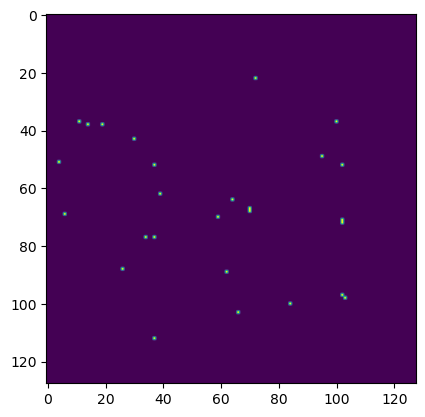

In [150]:
plt.imshow(a[0][0].cpu().detach().numpy())

## Test with synthetic data

In [41]:
def generate_data(sample_size = 1000, grid_size = 128, cell_size = 10, vehicle_num = 40, time_interval = 5):
    vehicle_num += random.randint(-10, 10)
    input = torch.zeros(sample_size, 3, grid_size, grid_size).to(device)
    output = torch.zeros(sample_size, 1, grid_size, grid_size).to(device)
    for i in range(sample_size):
        # randomly generate vehilce positions
        xs = np.random.randint(0, grid_size*cell_size, vehicle_num)
        ys = np.random.randint(0, grid_size*cell_size, vehicle_num)
        speeds_x = np.random.normal(0, 8, vehicle_num)
        speeds_y = np.random.normal(0, 8, vehicle_num)
        grid_x = xs // cell_size
        grid_y = ys // cell_size
        if input[i][0][grid_y][grid_x] == 0:
            input[i][0][grid_y][grid_x] += 1
            input[i][1][grid_y][grid_x] += speeds_x
            input[i][2][grid_y][grid_x] += speeds_y
        else:
            input[i][1][grid_y][grid_x] *= input[i][0][grid_y][grid_x]
            input[i][1][grid_y][grid_x] += speeds_x
            input[i][2][grid_y][grid_x] *= input[i][0][grid_y][grid_x]
            input[i][2][grid_y][grid_x] += speeds_y
            input[i][0][grid_y][grid_x] += 1
            input[i][1][grid_y][grid_x] /= input[i][0][grid_y][grid_x]
            input[i][2][grid_y][grid_x] /= input[i][0][grid_y][grid_x]

In [158]:
import os
import sys
import random
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import sumolib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import sys
import io
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Input shape: (batch, 3, H, W)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=0)
        self.deconv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.deconv3 = nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.batchnorm1(x)
        x = F.relu(self.conv3(x))
        x = self.batchnorm1(x)
        x = F.relu(self.deconv1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.deconv2(x))
        x = self.batchnorm1(x)
        x = F.relu(self.deconv3(x))
        x = self.conv4(x)
        return x

In [159]:
model = SimpleCNN().to(device)

# define our own loss function
def custom_loss(output, target):
    return torch.mean(torch.abs(output - target)) * 100
criterion = custom_loss
optimizer = optim.AdamW(model.parameters(), lr=0.01)

def gaussian_kernel(size, sigma=1, channels=1):
    x = torch.arange(-size // 2 + 1, size // 2 + 1, dtype=torch.float32)
    gaussian = torch.exp(-0.5 * (x / sigma) ** 2)
    gaussian = gaussian / gaussian.sum()
    gaussian_kernel = gaussian[:, None] * gaussian[None, :]
    gaussian_kernel = gaussian_kernel.expand(channels, 1, size, size)
    return gaussian_kernel

# Generate synthetic data
def generate_data(sample_size = 1000, grid_size = 64, cell_size = 20, vehicle_num = 40, time_interval = 5):
    vehicle_num += random.randint(-10, 10)
    input = torch.zeros(sample_size, 3, grid_size, grid_size).to(device)
    output = torch.zeros(sample_size, 1, grid_size, grid_size).to(device)
    for i in range(sample_size):
        # randomly generate vehilce positions
        xs = np.random.randint(0, grid_size*cell_size, vehicle_num)
        ys = np.random.randint(0, grid_size*cell_size, vehicle_num)
        speeds_xs = np.random.normal(0, 8, vehicle_num)
        speeds_ys = np.random.normal(0, 8, vehicle_num)
        future_xs = xs + speeds_xs * time_interval
        future_ys = ys + speeds_ys * time_interval
        for j in range(vehicle_num):
            grid_x = xs[j] // cell_size
            grid_y = ys[j] // cell_size
            speeds_x = speeds_xs[j]
            speeds_y = speeds_ys[j]
            future_x = int(future_xs[j] // cell_size)
            future_y = int(future_ys[j] // cell_size)
            if input[i][0][grid_y][grid_x] == 0:
                input[i][0][grid_y][grid_x] += 1
                input[i][1][grid_y][grid_x] += speeds_x
                input[i][2][grid_y][grid_x] += speeds_y
            else:
                input[i][1][grid_y][grid_x] *= input[i][0][grid_y][grid_x]
                input[i][1][grid_y][grid_x] += speeds_x
                input[i][2][grid_y][grid_x] *= input[i][0][grid_y][grid_x]
                input[i][2][grid_y][grid_x] += speeds_y
                input[i][0][grid_y][grid_x] += 1
                input[i][1][grid_y][grid_x] /= input[i][0][grid_y][grid_x]
                input[i][2][grid_y][grid_x] /= input[i][0][grid_y][grid_x]
            if future_x < grid_size and future_y < grid_size and future_x >= 0 and future_y >= 0:
                output[i][0][future_y][future_x] += 1
    # Apply Gaussian filter to the output
    kernel = gaussian_kernel(9, sigma=1, channels=1).to(device)
    output = F.conv2d(output, kernel, padding=4)
    dataset = TensorDataset(input, output)  # Create a TensorDataset
    return DataLoader(dataset, batch_size=100, shuffle=True)  # Create a DataLoader for batching

# Training the model
def train(model, criterion, optimizer, num_epochs, num_samples):
    model.train()
    for epoch in range(num_epochs):
        dataloader = generate_data(sample_size=num_samples)  # Get DataLoader
        total_loss = 0
        for inputs, targets in dataloader:
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            total_loss += loss.item()

        if (epoch+1) % 10 == 0:
            avg_loss = total_loss / len(dataloader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

# Parameters
num_epochs = 100
num_samples = 1000

# Train the model
train(model, criterion, optimizer, num_epochs, num_samples)

Epoch [10/100], Average Loss: 1.1845
Epoch [20/100], Average Loss: 0.9991
Epoch [30/100], Average Loss: 1.0998
Epoch [40/100], Average Loss: 1.1192
Epoch [50/100], Average Loss: 1.1877
Epoch [60/100], Average Loss: 1.0514
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/andyfu/miniconda3/envs/sumo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_14387/4159853410.py", line 89, in <module>
    train(model, criterion, optimizer, num_epochs, num_samples)
  File "/tmp/ipykernel_14387/4159853410.py", line 61, in train
    dataloader = generate_data(sample_size=num_samples)  # Get DataLoader
  File "/tmp/ipykernel_14387/4159853410.py", line -1, in generate_data
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/andyfu/miniconda3/envs/sumo/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/andyfu/miniconda3/envs/sumo/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    

In [160]:
def check_model(model, grid_size = 128, cell_size = 10):
    dl = generate_data(100, grid_size, cell_size, 40, 5)
    model.eval()
    for inputs, targets in dl:
        with torch.no_grad():
            pred = model(inputs)
            pred = F.relu(pred)
        pred = pred[0][0].cpu().detach().numpy()
        targets = targets[0][0].cpu().detach().numpy()
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # set the same color scale for both images
        axs[0].imshow(pred, cmap='gray')
        axs[1].imshow(targets, cmap='gray')
        axs[2].imshow(inputs[0][0].cpu().detach().numpy(), cmap='gray')
        plt.show()
        break

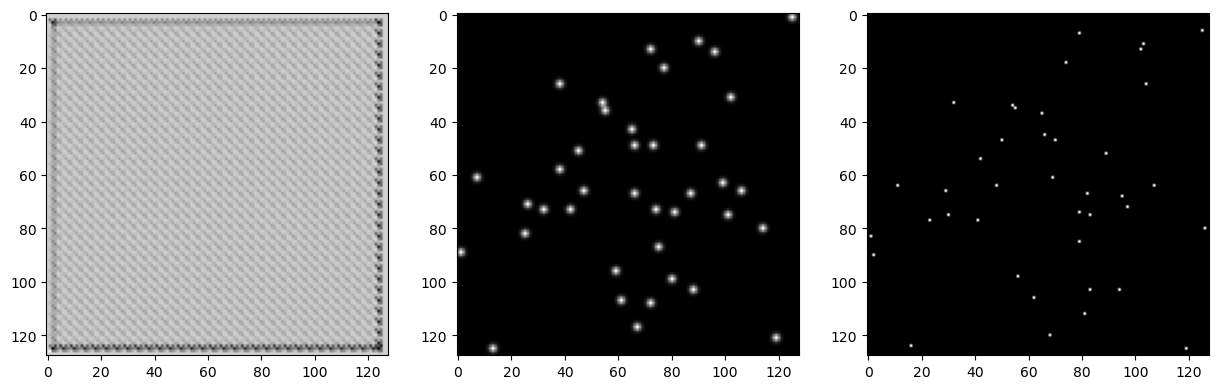

In [161]:
check_model(model)

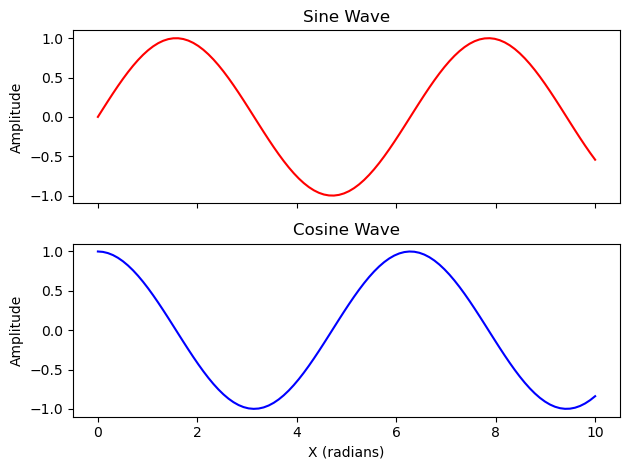

In [29]:
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plotting on the first subplot
ax1.plot(x, y1, 'r-')  # 'r-' is for a solid red line
ax1.set_title('Sine Wave')
ax1.set_ylabel('Amplitude')

# Plotting on the second subplot
ax2.plot(x, y2, 'b-')  # 'b-' is for a solid blue line
ax2.set_title('Cosine Wave')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('X (radians)')

# Automatically adjust subplot params to give specified padding
fig.tight_layout()

# Display the plot
plt.show()